<a href="https://colab.research.google.com/github/fahadshakeel23/DataScience/blob/main/Twitter_Data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 Load Twitter Data
* load the twitter dataset,set the inde, calculate the egagement ratio and filter out stocks with no significant twitter activiy.

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

import datetime as dt
import yfinance as yf
import os
plt.style.use('ggplot')


In [22]:
sentiment_df = pd.read_csv('/content/drive/MyDrive/sentiment_data.csv')

sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])
sentiment_df = sentiment_df.set_index(['date', 'symbol'])

sentiment_df['engagement_ratio'] = sentiment_df['twitterComments']/sentiment_df['twitterLikes']

sentiment_df = sentiment_df[(sentiment_df['twitterLikes']>20)&(sentiment_df['twitterComments']>10)]

sentiment_df

twitterPosts  twitterComments  twitterLikes  \
date       symbol                                                
2021-11-18 AAPL           811.0           2592.0       21674.0   
           AMD            150.0            675.0        2949.0   
           AMZN           557.0           1315.0       12969.0   
           ATVI            82.0             36.0         131.0   
           BA              61.0             55.0         342.0   
...                         ...              ...           ...   
2023-01-04 T              184.0           3409.0       14271.0   
           TSLA          6767.0         540711.0     3810688.0   
           TSN             35.0            168.0         460.0   
           V              132.0           1008.0        5943.0   
           XOM            212.0            374.0        2071.0   

                   twitterImpressions  twitterSentiment  engagement_ratio  
date       symbol                                                          
2021-11-18 AAPL             7981808.0               NaN          0.119590  
           AMD              1645270.0               NaN          0.228891  
           AMZN             5590695.0               NaN          0.101396  
           ATVI             1310715.0               NaN          0.274809  
           BA                425847.0               NaN          0.160819  
...                               ...               ...               ...  
2023-01-04 T                 884935.0          0.590457          0.238876  
           TSLA            55464921.0          0.543057          0.141893  
           TSN                57207.0          0.561900          0.365217  
           V                 139835.0          0.567286          0.169611  
           XOM               483389.0          0.588914          0.180589  

[25375 rows x 6 columns]

# 2 Aggregate Monthly and calculate avergae sentiment for the month
* Aggregate on a monthly level and calculate average monthly metric, for the one we choose.

In [23]:
aggregated_df = (sentiment_df.reset_index('symbol').groupby([pd.Grouper(freq='M'), 'symbol'])
                  [['engagement_ratio']].mean())

aggregated_df['rank'] = (aggregated_df.groupby(level=0)['engagement_ratio']
                         .transform(lambda x:x.rank(ascending=False)))

aggregated_df

/tmp/ipython-input-2101734987.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  aggregated_df = (sentiment_df.reset_index('symbol').groupby([pd.Grouper(freq='M'), 'symbol'])


engagement_ratio  rank
date       symbol                        
2021-11-30 AAL             0.203835  37.0
           AAPL            0.256318  23.0
           ABBV            0.244677  26.0
           ABT             0.313368  14.0
           AES             0.864613   2.0
...                             ...   ...
2023-01-31 TMO             0.333313  19.0
           TSLA            0.151992  72.0
           TSN             0.280553  30.0
           V               0.194045  60.0
           XOM             0.217904  53.0

[1109 rows x 2 columns]

# 3 Select top 5 stocks based on their cross-sectional ranking for each month
* Select top 5 stocks by rank for each month and fix the date to start at begining of next month

In [24]:
filtered_df = aggregated_df[aggregated_df['rank']<6].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'symbol'])

filtered_df.head(20)

engagement_ratio  rank
date       symbol                        
2021-12-01 AES             0.864613   2.0
           FCX             0.626323   5.0
           MNST            0.699721   3.0
           OXY             2.147741   1.0
           SLB             0.647374   4.0
2022-01-01 D               0.801994   5.0
           FCX             0.841220   4.0
           L               6.507246   1.0
           LUV             1.303215   2.0
           MA              0.883401   3.0
2022-02-01 AMD             0.715556   4.0
           D               1.136678   1.0
           FCX             0.655237   5.0
           LUV             1.035258   2.0
           MA              0.729063   3.0
2022-03-01 FCX             1.138332   2.0
           GILD            0.530886   5.0
           LUV             1.574377   1.0
           MRO             0.581748   4.0
           OXY             1.025579   3.0

# 4 Extract the stocks to form portfolios with the start of each new month
* create a dictionary containing start of month and corresponded selected stocks

In [26]:
dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:
  fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()

fixed_dates


{'2021-12-01': ['AES', 'FCX', 'MNST', 'OXY', 'SLB'],
 '2022-01-01': ['D', 'FCX', 'L', 'LUV', 'MA'],
 '2022-02-01': ['AMD', 'D', 'FCX', 'LUV', 'MA'],
 '2022-03-01': ['FCX', 'GILD', 'LUV', 'MRO', 'OXY'],
 '2022-04-01': ['A', 'CRM', 'PFE', 'PM', 'STZ'],
 '2022-05-01': ['AMD', 'CRM', 'CVX', 'J', 'KEY'],
 '2022-06-01': ['AMD', 'DD', 'FCX', 'KEY', 'LMT'],
 '2022-07-01': ['CB', 'CRM', 'DD', 'FCX', 'STZ'],
 '2022-08-01': ['A', 'DD', 'JPM', 'REGN', 'STZ'],
 '2022-09-01': ['ABT', 'DIS', 'L', 'META', 'MRNA'],
 '2022-10-01': ['J', 'KEY', 'L', 'META', 'MU'],
 '2022-11-01': ['A', 'DD', 'FCX', 'J', 'META'],
 '2022-12-01': ['AEP', 'AES', 'DD', 'J', 'STZ'],
 '2023-01-01': ['A', 'AES', 'DAL', 'J', 'KEY'],
 '2023-02-01': ['A', 'AES', 'BIIB', 'FCX', 'MDT']}

# Download fresh stock prices for only selected/shortlisted stocks

In [27]:
stocks_list = sentiment_df.index.get_level_values('symbol').unique().tolist()

prices_df = yf.download(tickers=stocks_list,
                        start='2021-01-01',
                        end='2023-01-01')

/tmp/ipython-input-1962175899.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices_df = yf.download(tickers=stocks_list,
[*********************100%***********************]  85 of 85 completed
ERROR:yfinance:
2 Failed downloads:
ERROR:yfinance:['MRO', 'ATVI']: YFTzMissingError('possibly delisted; no timezone found')


# Calculate portfolio returns with monthly rebalancing

In [41]:
returns_df = np.log(prices_df['Close']).diff().dropna()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():

  end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd()).strftime('%Y-%m-%d')

  cols = fixed_dates[start_date]

  temp_df = returns_df[start_date:end_date][cols].mean(axis=1).to_frame('portfolio_return')

  portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)

portfolio_df


,portfolio_return
Date,


# Download NASDAQ/QQQ prices and calculate returns to compare our strategy

In [48]:
qqq_df = yf.download(tickers='QQQ',
                     start='2021-01-01',
                     end='2023-03-01')

# Calculate log returns diff
qqq_ret = np.log(qqq_df['Close']).diff()

# Since qqq_ret might be a DataFrame, rename columns directly
qqq_ret.columns = ['nasdaq_returns']

# Merge with your existing portfolio_df (assumed to exist)
portfolio_df = portfolio_df.merge(qqq_ret, left_index=True, right_index=True)

# Show final result
portfolio_df

/tmp/ipython-input-3539873975.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  qqq_df = yf.download(tickers='QQQ',
[*********************100%***********************]  1 of 1 completed


,portfolio_return,nasdaq_returns
Date,,


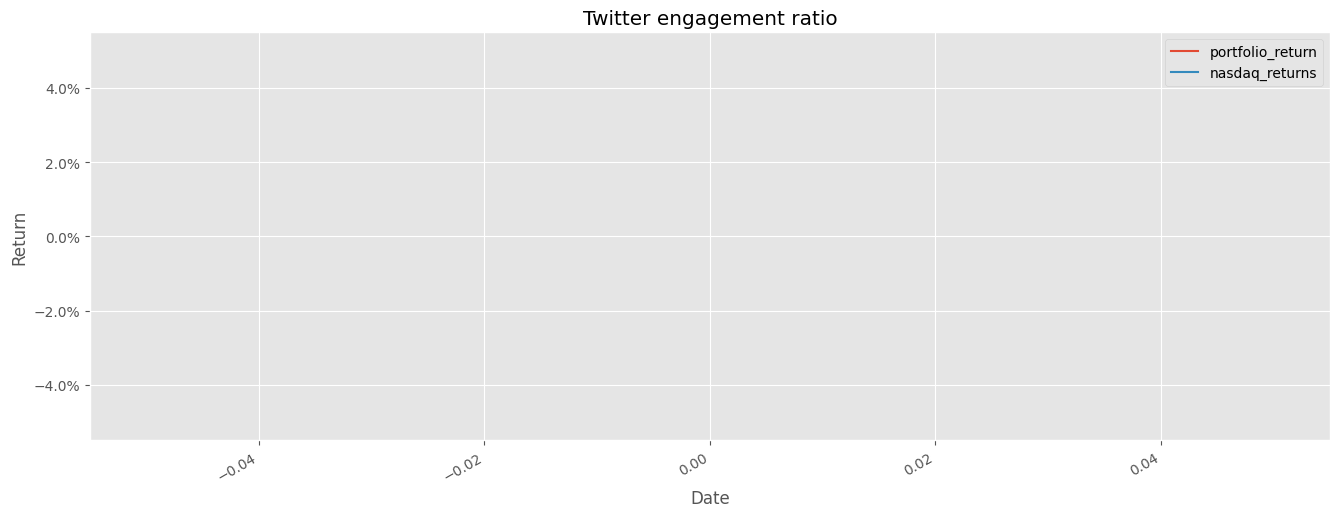

In [53]:
portfolios_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum()).sub(1)

portfolios_cumulative_return.plot(figsize=(16,6))

plt.title("Twitter engagement ratio")

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()


